In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. Quando o ajuste é abordado como um problema de otimização numétrica, ele é a base de boa parte dos conceitos sobre redes neurais e iremos explorá-lo aqui como uma forma de introdução às redes neurais.

## Conjunto de dados: Flôres Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris: o comprimento das sépalas e o comprimento da pétalas. A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estamos trabalhando com apenas uma propriedade, ou característica ou *feature* do objeto. Temos ao todo 50 amostras de uma das variedades.

## Dados: leitura e visualização

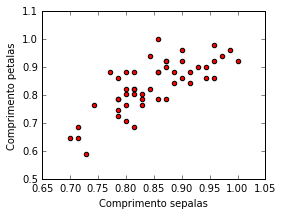

In [77]:
from sklearn import datasets

iris = datasets.load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
X = data[:,0]
Y = data[:,1]
X /= X.max()    # Importante ver o efeito da normalização
Y /= Y.max()
#Y = 2*X        # útil para verificar se o programa está funcionando

plt.figure(1, figsize=(4, 3))
plt.scatter(X, Y, c='r')
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Reta de ajuste

A reta de ajuste será dada por:

$$ y = w_0 + w_1 x $$

onde $w_1$ é o coeficiente angular da reta e $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*. $x$ é a variável de entrada (comprimento das sépalas) e $y$ é a predição (comprimento das pétalas).

### Programação Matricial

Como iremos trabalhar com várias amostras, dezenas, centenas, milhares, centenas de milhares, é mais eficiente trabalhar com vetores, matrizes e *arrays* por ser uma forma muito mais eficiente de se programar e de se processar. Talvez essa seja uma das principais dificuldades de programadores de linguagens "estilo C" onde é usual o uso de laços explícitos nos cálculos. Neste curso iremos usar intensivamente o NumPy que é o pacote de *arrays* numéricos que permitem programação matricial de forma muito eficiente.

### Representação matricial da equação linear

Supondo que tem $n$ amostras, as equações para todas as amostram ficam:

$$ \begin{bmatrix}
y^{(0)}\\ 
y^{(1)}\\
\\
y^{(n)}  \end{bmatrix} = \begin{bmatrix}
w_0 &+& x^{(0)} w_1\\ 
w_0 &+& x^{(1)} w_1\\
\\ 
w_0 &+& x^{(n)} w_1\\ 
\end{bmatrix} $$

Para facilitar a conversão matricial dos dois parâmetros da reta: $ w_0$ e $w_1 $, é usual fazer as seguintes transformações:

$$ \begin{bmatrix}
y^{(0)}\\ 
y^{(1)}\\
\\
y^{(n)}  \end{bmatrix} = \begin{bmatrix}
1\ w_0&+&x^{(0)} w_1\\ 
1\ w_0&+&x^{(1)} w_1\\
\\ 
1\ w_0&+&x^{(n)}  w_1\\ 
\end{bmatrix} $$

que é equivalente à operação matricial:

$$ \begin{bmatrix}
y^{(0)}\\ 
y^{(1)}\\
\\
y^{(n)} 
\end{bmatrix} = \begin{bmatrix}
1 & x^{(0)} \\ 
1 & x^{(1)}\\
\\ 
1 & x^{(n)} \\ 
\end{bmatrix}\begin{bmatrix}
w_0\\ 
w_1
\end{bmatrix} $$

Em notação matricial:

$$ \boldsymbol{Y} = \boldsymbol{X} \boldsymbol{W} $$.

A multiplicação de matrizes é implementada em Python/Numpy usando o operador `dot`. Temos
duas notações principais:  `X.dot(W)` ou `np.dot(X,W)`. As matrizes são caracterizadas pelas suas dimensões que no NumPy são denominados `shape` que para matrizes é organizado em `(linhas, colunas)`. Na multiplicação $\boldsymbol{X} \boldsymbol{W}$, `X.shape=(n,2)` e `W.shape=(2,1)`, cujo resultado da multiplicação será `(n,2)(2,1)->(n,1)` que é o mesmo shape de $\boldsymbol{Y}$.

Operações matriciais tornam o código conciso, poderoso e simples, porém, é comum aparecer erros nestas operações e uma das melhores formas de verificar isso é imprimindo o shape das
matrizes em uso.

### Aumento das dimensões

Uma das principais vantagens da representação matricial acima é a facilidade de aumento da
dimensionalidade do problema, sem mudança da equação matricial e consequentemente sem
mudança do código do programa. Se no problema da estimativa da largura da pétula, quisermos
utilizar não apenas uma variável de entrada, mas três. As únicas modificações necessárias são
mudar as matrizes $\boldsymbol{X}$ e $\boldsymbol{W}$:

$$\begin{bmatrix}
y^{(0)}\\ 
y^{(1)}\\
\\
y^{(n)}
\end{bmatrix} = \begin{bmatrix}
1 & x_1^{(0)} & x_2^{(0)} & x_3^{(0)} \\ 
1 & x_1^{(1)} & x_2^{(1)} & x_3^{(1)}\\
\\ 
1 & x_1^{(n)} & x_2^{(n)} & x_3^{(n)} \\ 
\end{bmatrix}\begin{bmatrix}
w_0\\ 
w_1 \\
w_2\\
w_3
\end{bmatrix}$$

Observe que agora as dimensões na multiplicação são: `(n,1)=(n,4).dot(n,1)`.

## Formulação do problema

Dado um conjunto de pontos $(x^{(i)},y^{(i)})$, queremos encontrar uma equação linear na
forma $ \hat{y} = w_0 + w_1\ x $ de modo que o erro médio quadrático $ (y^{(i)} - \hat{y^{(i)}})^2 $ de todas as amostras seja mínimo. Isto é:

$$ \frac{1}{2n} \sum_{i \in (0,n-1)} (y^{(i)} - (w_0 + w_1\ x^{(i)})^2 $$

Em notação matricial:

$$ J(W)=\frac{1}{2n}(XW−Y)^T(XW−Y) $$

A seguir é mostrado uma implementação matricial desta função:



In [78]:
def compute_cost(X, Y, W):
    '''
    Compute cost for linear regression
    '''
    n = Y.size  #Number of training samples
    E = X.dot(W) - Y
    J = (E.T).dot(E)/ (2. * n)
    return J

O problema então se resume em encontrar os coeficientes de $\boldsymbol{W}$ que minimizem $J(\boldsymbol{W})$. Existem várias formas de se realizar esta otimização. Para fazer uma analogia com as redes neurais, a otimização será obtiva por método de cálculo numérico
conhecido como "gradiente descendente". Como o gradiente de uma função aponta sempre para os valores mais altos da função, o método do gradiente descendente consiste em atualizar o valor de $\boldsymbol{W}$ subtraindo-o proporcionalmente do gradiente, isto é, indo na direção contrária do gradiente na expectativa de que iremos encontrar valores menores.

Na equação da atualização do $\boldsymbol{W}$ a seguir, o fator $\eta$ é denominado *learning rate*. Ele é um parâmetro de ajuste fundamental para o sucesso da otimização: 

$$ \boldsymbol{W} = \boldsymbol{W} − \eta \Delta J(\boldsymbol{W}) $$

Desta forma então, calculando-se o gradiente de $J(\boldsymbol{W})$ e substituindo na equação acima temos:

$$ \boldsymbol{W} = \boldsymbol{W} − \eta \frac{1}{n}(X^T(XW−Y)) $$

Esta equação é implementada dentro da função `gradient_descent`.

O esquema da otimização é representado pelo diagrama a seguir:

![](../figures/gradientDescentDiagram.png)


In [ ]:
def gradient_descent(X, Y, eta, num_iters):
    '''
    Perform gradient descent to learn W
    by taking num_items gradient steps with learning
    rate eta
    '''
    n = Y.size
    W = np.zeros(shape=(2, 1))
    J_history = np.zeros(shape=(num_iters, ))
    W_history = np.zeros(shape=(2,num_iters))

    for i in range(num_iters):
        errors = (X.T).dot(X.dot(W) - Y)
        W = W - eta * (1.0 / n) * errors
    
        W_history[:,i] = W[:,0]
        J_history[i] = compute_cost(X, Y, W)
    return W, J_history, W_history

X.shape: (50,) float64
Y.shape: (50,) float64


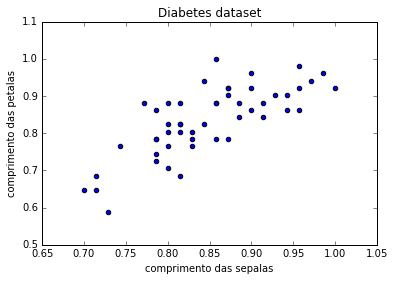

In [85]:
print 'X.shape:', X.shape, X.dtype
print 'Y.shape:', Y.shape, Y.dtype
#print X[:10],y[:10]

#Plot the data
plt.scatter(X, Y, marker='o', c='b')
plt.title('Dataset Iris')
plt.xlabel('comprimento das sepalas')
plt.ylabel('comprimento das petalas')
plt.show()

X_bias.shape: (50, 2)
final cost: [[ 0.00179468]]
W_optimal: [[ 0.03945396]
 [ 0.93850228]]


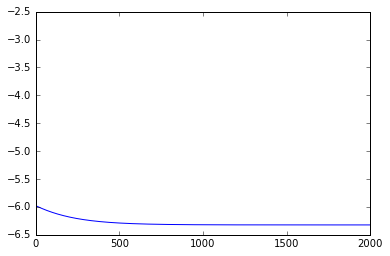

In [86]:
#number of training samples
n = Y.size

#Add a column of ones to X (interception data)
X_bias = np.hstack([np.ones(shape=(n, 1)), X.reshape(-1,1)])
print 'X_bias.shape:',X_bias.shape
Y_matrix = Y.reshape(-1,1)


#Some gradient descent settings
iterations = 2000
eta = 0.8

W_optimal, J_history, W_history = gradient_descent(X_bias, Y_matrix, eta, iterations)

print 'final cost:', compute_cost(X_bias, Y_matrix, W_optimal)
print 'W_optimal:', W_optimal

plt.plot(np.log(J_history)) # mostrando log para amplificar valores baixos
plt.show()



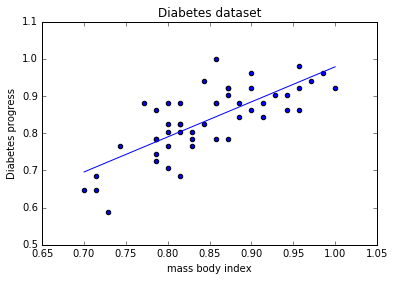

In [81]:
#Plot the results
#Plot the data
plt.scatter(X, Y, marker='o', c='b')
plt.title('Iris dataset')
plt.xlabel('mass body index')
plt.ylabel('Diabetes progress')

x = np.linspace(X.min(),X.max(),100).reshape(-1,1)
x_bias = np.hstack([np.ones_like(x),x])
result = x_bias.dot(W_optimal).flatten()
plt.plot(x, result)
plt.show()

Wmin: [-0.59564098 -0.22762549]
Wmax: [ 1.30017343  1.52713284]
(100, 100)
(2, 10000)
(50, 2)
J.shape: (10000,)
W_history.shape: (2, 15500)


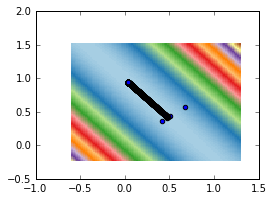

In [82]:

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Wmin = W_history.min(axis=1)
Wmax = W_history.max(axis=1)
D = Wmax - Wmin
Wmin -= D
Wmax += D
print 'Wmin:', Wmin
print 'Wmax:', Wmax
xx, yy = np.meshgrid(np.linspace(Wmin[0], Wmax[0], 100), np.linspace(Wmin[1], Wmax[1], 100))
W_grid = np.c_[xx.ravel(), yy.ravel()].T
print xx.shape
print W_grid.shape
print X_bias.shape

n = Y_matrix.size

E = ((X_bias.dot(W_grid) - Y_matrix)**2).sum(axis=0)

J = E/(2. * n)
print 'J.shape:', J.shape
print 'W_history.shape:', W_history.shape

# Put the result into a color plot
J = J.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, J,cmap=plt.cm.Paired)

plt.scatter(W_history[0],W_history[1])
plt.show()



In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
print matplotlib.__version__
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)#, projection='3d')
#ax = Axes3D(fig)

ax.plot_surface(xx, yy, J, rstride=1, cstride=1, color='b', alpha=0.5)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Cost')
ax.view_init(elev=30., azim=30)
#ax.plot([theta[0]], [theta[1]], [cost[-1]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);

## Referências

- [An Introduction to Gradient Descent in Python by Till Bergamann](http://tillbergmann.com/blog/python-gradient-descent.html) Blog, Agosto 2015.
